In [48]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

In [49]:
import numpy as np

In [50]:

train = pd.read_json('train_tensor.json')
test = pd.read_json('test_tensor.json')
valid = pd.read_json('valid_tensor.json')

In [51]:
train = train.reset_index(drop=True)

In [56]:
test = test.reset_index(drop=True)

In [57]:
valid = valid.reset_index(drop=True)

In [58]:
test

,Unnamed: 0,Dialogue_ID,Utterance,Emotion,Sentiment,Tokenization,Length,Tensor
0,0,27000,好了没事了,0,1,"['好', '了', '没事', '了']",4,"[[0.064666003, -0.30551698800000004, 0.1139279..."
1,1,27000,谢谢你哦,0,1,"['谢谢', '你', '哦']",3,"[[0.2339970022, -0.5972849727, 0.1576009989, -..."
2,2,27000,没关系,7,0,['没关系'],1,"[[0.27745199200000004, -0.6009050012, 0.303104..."
3,3,27000,喂,8,0,['喂'],1,"[[0.08525600280000001, -0.9938610196000001, -0..."
4,4,27000,没事吧,8,0,"['没事', '吧']",2,"[[0.0474819988, -0.6579239964, 0.1286790073, 0..."
...,...,...,...,...,...,...,...,...
24306,24607,37224,老哥说实话你哪儿都好,5,2,"['老哥', '说', '实话', '你', '哪儿', '都', '好']",7,"[[0.1190140024, -0.8823390007, -0.034031, -0.3..."
24307,24608,37224,关键时刻有点笨,5,2,"['关键', '时刻', '有点', '笨']",4,"[[0.31442201140000003, -0.207535997, 0.1764940..."
24308,24609,37226,对,1,0,['对'],1,"[[0.2566100061, -0.4985559881, -0.055897001200..."
24309,24610,37226,小雪、小雨,7,0,"['小雪', '、', '小雨']",3,"[[0.6294760108, -0.6717460155, 0.1621019989000..."


In [59]:
import tensorflow as tf

if tf.config.list_physical_devices('GPU'):
    print("GPU is available")
else:
    print("GPU is not available")
    
typecount = 3

GPU is available


In [60]:
def torch2tf(pytorch_tensor): 
    # As we decided to use PyTorch at first 
    # the output is a Torch tensor 
    # so we need to change it to Tensorflow tensor
    numpy_array = pytorch_tensor.numpy()
    tensorflow_tensor = tf.convert_to_tensor(numpy_array)
    return tensorflow_tensor

In [64]:
def data_processing(dataset):
    X_raw = dataset['Tensor']
    Y = torch.Tensor(dataset['Sentiment'])
    dialogue = dataset['Dialogue_ID']
    max_n = 15
    X_prev_1 = torch.zeros((len(X_raw), max_n, 100))
    X_prev_2 = torch.zeros((len(X_raw), max_n, 100))
    X = torch.zeros((len(X_raw), max_n, 100))
    for i in range(len(X_raw)):
        t = torch.Tensor(np.array(X_raw[i]))
        if t.shape[0]>max_n:
            t = t[:max_n,:]
        X[i,:t.shape[0],:] = t
        if i == 0 or dialogue[i-1] != dialogue[i]:
            continue
        elif i == 1 or dialogue[i-2] != dialogue[i]:
            t_prev = torch.Tensor(np.array(X_raw[i-1]))
            if t_prev.shape[0]>max_n:
                t_prev = t_prev[:max_n,:]
            X_prev_2[i,:t_prev.shape[0],:] = t_prev
        else:
            t_prev = torch.Tensor(np.array(X_raw[i-1]))
            if t_prev.shape[0]>max_n:
                t_prev = t_prev[:max_n,:]
            X_prev_2[i,:t_prev.shape[0],:] = t_prev
            t_next = torch.Tensor(np.array(X_raw[i-2]))
            if t_next.shape[0]>max_n:
                t_next = t_next[:max_n,:]
            X_prev_1[i,:t_next.shape[0],:] = t_next
    X_prev_1,X_prev_2,X = torch2tf(X_prev_1),torch2tf(X_prev_2),torch2tf(X)
    Y = torch2tf(Y)
    Y = tf.one_hot(tf.cast(Y, dtype=tf.uint8), depth=typecount)
    return X_prev_1,X_prev_2,X,Y

In [181]:

print(train["Sentiment"].value_counts())
print(test["Sentiment"].value_counts())
print(valid["Sentiment"].value_counts())
emotions = list(train["Sentiment"].value_counts().index)
typecount = len(emotions)


Sentiment
0    40360
1    26804
2    13198
Name: count, dtype: int64
Sentiment
0    11485
1     7010
2     5816
Name: count, dtype: int64
Sentiment
0    5497
1    2746
2    1520
Name: count, dtype: int64


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_9328\2962184427.py:14: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


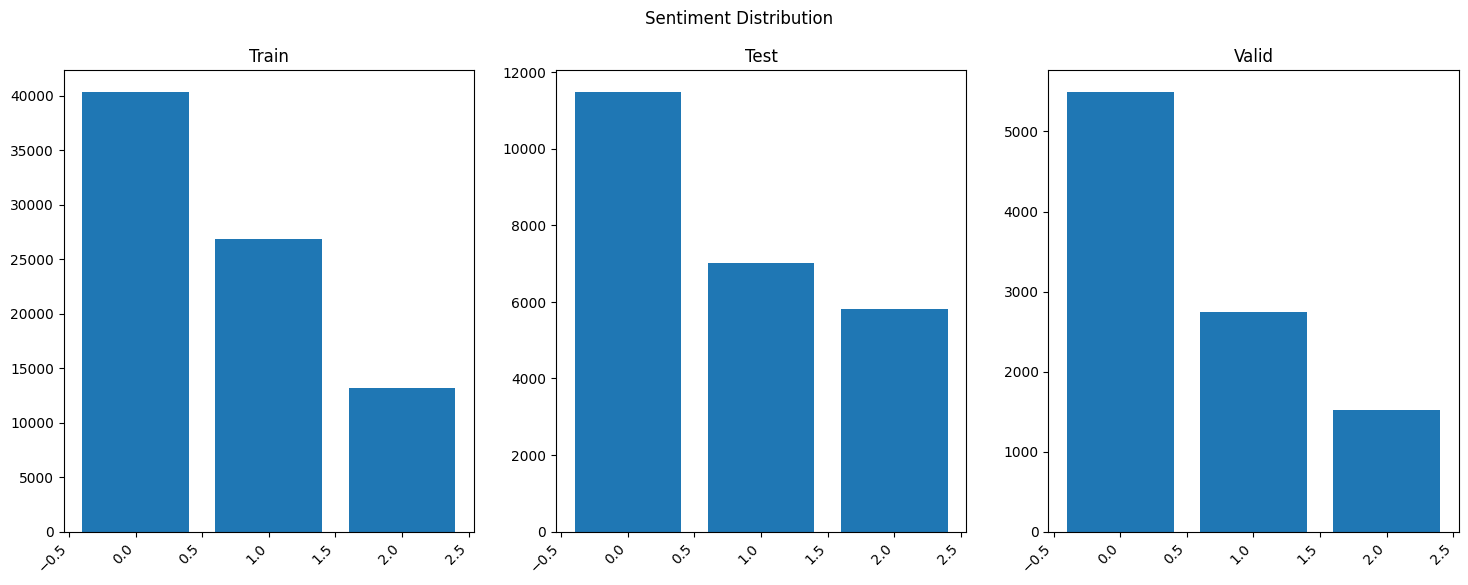

In [190]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(18,6))
fig.suptitle('Sentiment Distribution')
count_train = train.loc[:, "Sentiment"].value_counts()
count_test = test.loc[:, "Sentiment"].value_counts()
count_valid = valid.loc[:, "Sentiment"].value_counts()
ax1.bar(count_train.index,count_train)
ax1.set_title("Train")
ax2.bar(count_test.index,count_test)
ax2.set_title("Test")
ax3.bar(count_valid.index,count_valid)
ax3.set_title("Valid")
for ax in ax1,ax2,ax3:
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right")
fig.show()

In [69]:
X_train_prev_1,X_train_prev_2,X_train,Y_train= data_processing(train)
print(X_train.shape)

X_valid_prev_1,X_valid_prev_2,X_valid,Y_valid = data_processing(valid) 
print(X_valid.shape)

(80362, 15, 100)
(9763, 15, 100)


In [143]:
X_test_prev_1,X_test_prev_2,X_test,Y_test = data_processing(test) 

In [182]:
print(X_test.shape)

(24311, 15, 100)


In [75]:
for i in range(10):
    print(X_train[i])

tf.Tensor(
[[ 0.336415 -0.326726  0.144301 ... -0.064117  0.129759 -0.227933]
 [ 0.115907 -0.474288  0.086524 ...  0.29751  -0.07646  -0.231796]
 [ 0.        0.        0.       ...  0.        0.        0.      ]
 ...
 [ 0.        0.        0.       ...  0.        0.        0.      ]
 [ 0.        0.        0.       ...  0.        0.        0.      ]
 [ 0.        0.        0.       ...  0.        0.        0.      ]], shape=(15, 100), dtype=float32)
tf.Tensor(
[[ 0.013672 -0.398774  0.213491 ... -0.274543  0.289768 -0.52969 ]
 [ 0.047482 -0.657924  0.128679 ...  0.065943 -0.126883 -0.725823]
 [ 0.100075 -0.375134 -0.007729 ...  0.42156  -0.047755 -0.164494]
 ...
 [ 0.        0.        0.       ...  0.        0.        0.      ]
 [ 0.        0.        0.       ...  0.        0.        0.      ]
 [ 0.        0.        0.       ...  0.        0.        0.      ]], shape=(15, 100), dtype=float32)
tf.Tensor(
[[ 0.254297 -0.246311  0.004492 ...  0.253641 -0.162876 -0.276653]
 [ 0.39207  -0.548

In [76]:
print(Y_train[:100])

tf.Tensor(
[[0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 

In [80]:
print(X_train[0], Y_train[0])
print(X_train[1], Y_train[1])
print(X_train[5000], Y_train[5000])
print(X_train[5001], Y_train[5001])
print(X_train[10000], Y_train[10000])
print(X_train[10001], Y_train[10001])

tf.Tensor(
[[ 0.336415 -0.326726  0.144301 ... -0.064117  0.129759 -0.227933]
 [ 0.115907 -0.474288  0.086524 ...  0.29751  -0.07646  -0.231796]
 [ 0.        0.        0.       ...  0.        0.        0.      ]
 ...
 [ 0.        0.        0.       ...  0.        0.        0.      ]
 [ 0.        0.        0.       ...  0.        0.        0.      ]
 [ 0.        0.        0.       ...  0.        0.        0.      ]], shape=(15, 100), dtype=float32) tf.Tensor([0. 1. 0.], shape=(3,), dtype=float32)
tf.Tensor(
[[ 0.013672 -0.398774  0.213491 ... -0.274543  0.289768 -0.52969 ]
 [ 0.047482 -0.657924  0.128679 ...  0.065943 -0.126883 -0.725823]
 [ 0.100075 -0.375134 -0.007729 ...  0.42156  -0.047755 -0.164494]
 ...
 [ 0.        0.        0.       ...  0.        0.        0.      ]
 [ 0.        0.        0.       ...  0.        0.        0.      ]
 [ 0.        0.        0.       ...  0.        0.        0.      ]], shape=(15, 100), dtype=float32) tf.Tensor([0. 1. 0.], shape=(3,), dtype=float32

In [82]:
print(valid['Sentiment'].value_counts())

Sentiment
0    5497
1    2746
2    1520
Name: count, dtype: int64


In [83]:
print(train['Sentiment'].value_counts())

Sentiment
0    40360
1    26804
2    13198
Name: count, dtype: int64


In [96]:
import keras
from keras.layers import LSTM, Dense, Activation, Masking, TimeDistributed, Bidirectional, BatchNormalization,Concatenate,Reshape
from keras.models import Sequential, load_model
from keras import regularizers
from keras.utils import plot_model

In [199]:
h_n = 100
epochs = 100
callbacks = [
    keras.callbacks.ModelCheckpoint("checkpoint/save_at_{epoch}.keras"),
     keras.callbacks.EarlyStopping(
     monitor="val_loss",
#     min_delta=0,
     patience=100,
#     verbose=0,
#     mode="auto",
#     baseline=None,
     #restore_best_weights=True,
 )
]

In [194]:
def make_model(input_shape,h_n = 100, num_classes=3):
    X_prev_1 = keras.Input(shape=input_shape, name="X_prev Input")
    X_prev_2 = keras.Input(shape=input_shape, name="X Input")
    X = keras.Input(shape=input_shape, name="X_next Input")
    # masked1 = Masking(0)(X_prev_1)
    # masked2 = Masking(0)(X_prev_2)
    # masked3 = Masking(0)(X)
    lstm = Bidirectional(LSTM(256, dropout=0.2, kernel_regularizer=regularizers.L2(0.0001)))

    lstm1 = lstm(X_prev_1)
    lstm2 = lstm(X_prev_2)
    lstm3 = lstm(X)

    inp = Concatenate(axis=-1)([lstm1, lstm2, lstm3])

    inp = Reshape((3, 2*256, )) (inp)
    tmp = LSTM(300, dropout=0.1, recurrent_dropout=0.1,kernel_regularizer=regularizers.L2(0.0001), name="LSTM_layer")(inp)
    bn = BatchNormalization()(tmp)
    outputs = Dense(num_classes, activation="softmax", name="Output_layer")(bn)
    return keras.Model([X_prev_1,X_prev_2,X], outputs)

In [200]:
model = make_model(input_shape=(15,100), num_classes=3)
print(model.summary())

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 X_prev Input (InputLayer)      [(None, 15, 100)]    0           []                               
                                                                                                  
 X Input (InputLayer)           [(None, 15, 100)]    0           []                               
                                                                                                  
 X_next Input (InputLayer)      [(None, 15, 100)]    0           []                               
                                                                                                  
 bidirectional_7 (Bidirectional  (None, 512)         731136      ['X_prev Input[0][0]',           
 )                                                                'X Input[0][0]',          

In [201]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss="categorical_crossentropy", 
    metrics=["accuracy"]
)

In [202]:
history = model.fit(
    [X_train_prev_1,X_train_prev_2,X_train],Y_train,
    epochs=epochs,
    callbacks=callbacks,
    batch_size=256,
    validation_data=([X_valid_prev_1,X_valid_prev_2,X_valid],Y_valid)
)

Epoch 1/100
314/314 [==============================] - 22s 50ms/step - loss: 1.0203 - accuracy: 0.5276 - val_loss: 0.9855 - val_accuracy: 0.5634
Epoch 2/100
314/314 [==============================] - 14s 45ms/step - loss: 0.9755 - accuracy: 0.5417 - val_loss: 0.9581 - val_accuracy: 0.5892
Epoch 3/100
314/314 [==============================] - 14s 44ms/step - loss: 0.9639 - accuracy: 0.5467 - val_loss: 0.9145 - val_accuracy: 0.5911
Epoch 4/100
314/314 [==============================] - 14s 44ms/step - loss: 0.9568 - accuracy: 0.5483 - val_loss: 0.9321 - val_accuracy: 0.5881
Epoch 5/100
314/314 [==============================] - 14s 44ms/step - loss: 0.9522 - accuracy: 0.5501 - val_loss: 0.9075 - val_accuracy: 0.5830
Epoch 6/100
314/314 [==============================] - 14s 44ms/step - loss: 0.9477 - accuracy: 0.5525 - val_loss: 0.9162 - val_accuracy: 0.5898
Epoch 7/100
314/314 [==============================] - 14s 44ms/step - loss: 0.9451 - accuracy: 0.5533 - val_loss: 0.9174 - val_ac

In [203]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


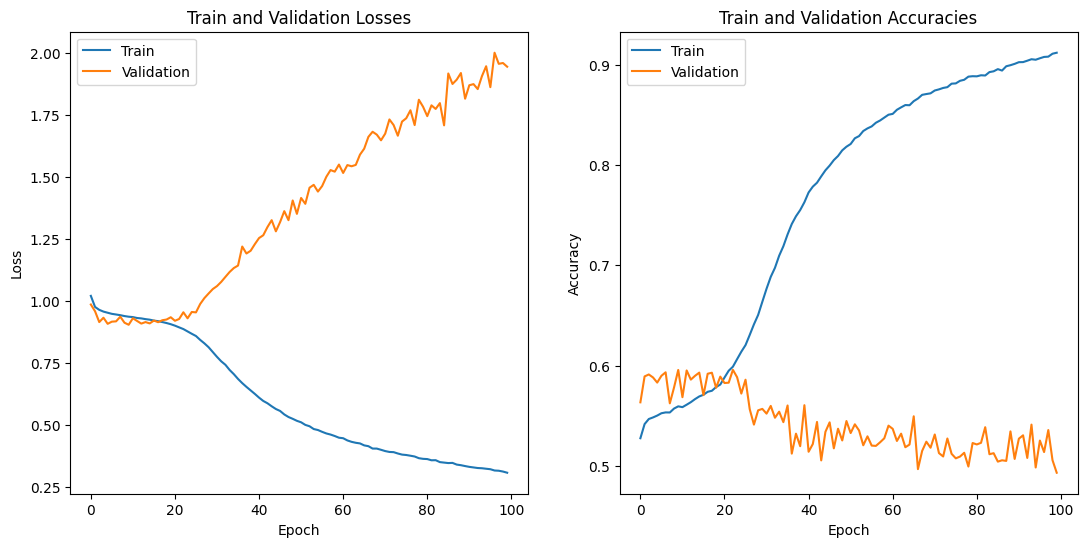

In [204]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 6))

ax1.plot(history.history['loss'], label='Train')
ax1.plot(history.history['val_loss'], label='Validation')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Train and Validation Losses')
ax1.legend()

ax2.plot(history.history['accuracy'], label='Train')
ax2.plot(history.history['val_accuracy'], label='Validation')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('Train and Validation Accuracies')
ax2.legend()

plt.show()

In [205]:
model = load_model('./checkpoint/save_at_15.keras')

In [206]:
from sklearn.metrics import confusion_matrix

In [207]:
def get_pred(model, inputs, labels):
    y_true =tf.math.argmax(labels,axis=1)
    y_pred = model.predict(inputs)
    y_pred = y_pred.argmax(axis=1)
    return y_true, y_pred

In [208]:
y_true_train, y_pred_train = get_pred(model,[X_train_prev_1,X_train_prev_2,X_train],Y_train)
y_true_valid, y_pred_valid = get_pred(model,[X_valid_prev_1,X_valid_prev_2,X_valid],Y_valid)
y_true_test, y_pred_test = get_pred(model,[X_test_prev_1,X_test_prev_2,X_test],Y_test)

760/760 [==============================] - 9s 12ms/step


In [209]:
cm = confusion_matrix(y_true_train,y_pred_train )
cm2 = confusion_matrix(y_true_valid, y_pred_valid)
cm3 = confusion_matrix(y_true_test, y_pred_test)

In [213]:
print(cm3)


[[8902 1083 1500]
 [4250 1459 1301]
 [3110  838 1868]]


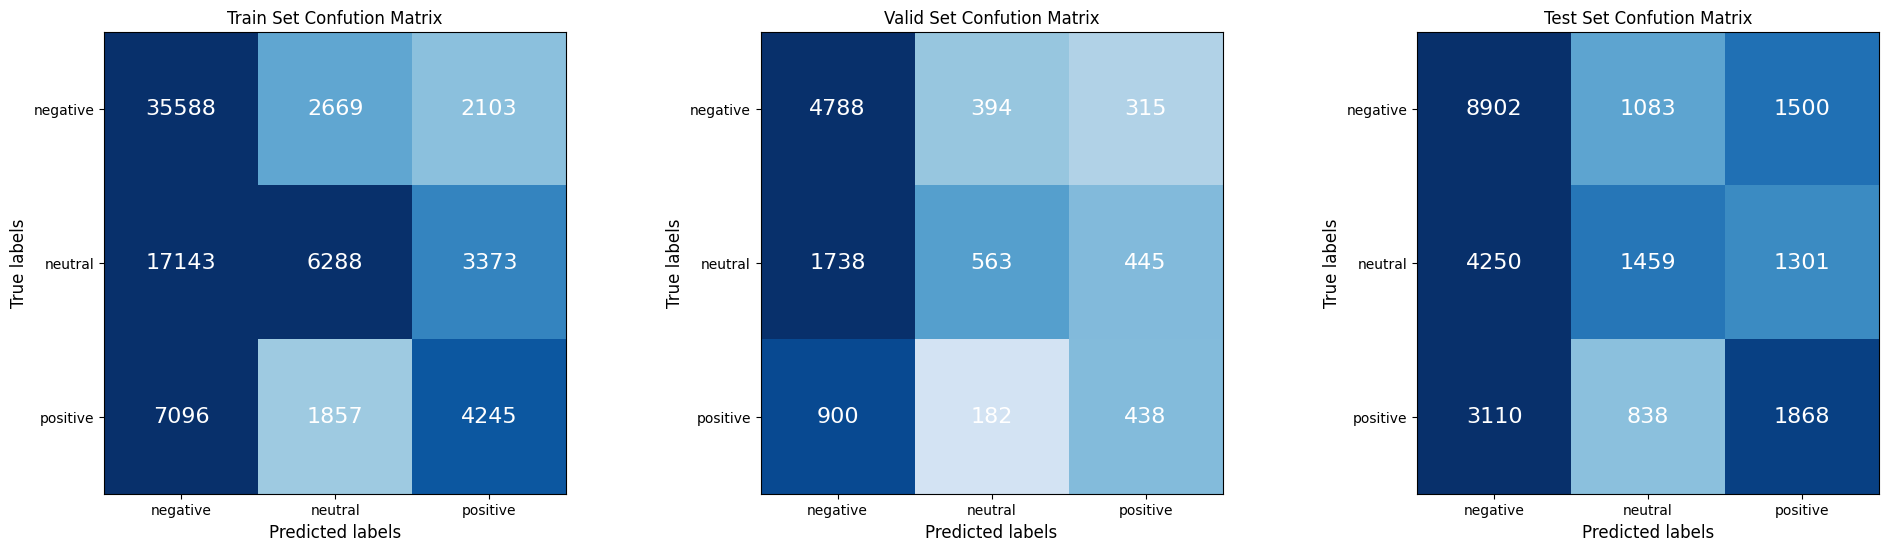

In [216]:
fig, (ax1, ax2,ax3) = plt.subplots(1,3,figsize=(24, 6))
ax1.imshow(cm, cmap='Blues', vmin=0, vmax=5000)
ax1.grid(False)
ax1.set_xlabel('Predicted labels', fontsize=12, color='black')
ax1.set_ylabel('True labels', fontsize=12, color='black')
ax1.set_xticks(np.arange(3))
ax1.set_yticks(np.arange(3))
ax1.set_xticklabels(["negative","neutral","positive"], fontsize=10, color='black')
ax1.set_yticklabels(["negative","neutral","positive"], fontsize=10, color='black')

for i in range(3):
    for j in range(3):
        ax1.text(j, i, cm[i, j], ha='center', va='center', color='white', fontsize=16)

ax2.imshow(cm2, cmap='Blues', vmin=0, vmax=1000)
ax2.grid(False)
ax2.set_xlabel('Predicted labels', fontsize=12, color='black')
ax2.set_ylabel('True labels', fontsize=12, color='black')
ax2.set_xticks(np.arange(3))
ax2.set_yticks(np.arange(3))
ax2.set_xticklabels(["negative","neutral","positive"], fontsize=10, color='black')
ax2.set_yticklabels(["negative","neutral","positive"], fontsize=10, color='black')

for i in range(3):
    for j in range(3):
        ax2.text(j, i, cm2[i, j], ha='center', va='center', color='white', fontsize=16)
        
ax3.imshow(cm3, cmap='Blues', vmin=0, vmax=2000)
ax3.grid(False)
ax3.set_xlabel('Predicted labels', fontsize=12, color='black')
ax3.set_ylabel('True labels', fontsize=12, color='black')
ax3.set_xticks(np.arange(3))
ax3.set_yticks(np.arange(3))
ax3.set_xticklabels(["negative","neutral","positive"], fontsize=10, color='black')
ax3.set_yticklabels(["negative","neutral","positive"], fontsize=10, color='black')

for i in range(3):
    for j in range(3):
        ax3.text(j, i, cm3[i, j], ha='center', va='center', color='white', fontsize=16)

ax1.set_title("Train Set Confution Matrix")
ax2.set_title("Valid Set Confution Matrix")
ax3.set_title("Test Set Confution Matrix")


plt.show()

In [217]:
def f1_score(pred_labels, true_labels, num_classes):


    conf_matrix = np.zeros((num_classes, num_classes), dtype = "int32")
    for i in range(len(pred_labels)):
        conf_matrix[pred_labels[i], true_labels[i]] += 1

    for i in range(num_classes):
      for j in range(num_classes):
        print("{:5d}".format(conf_matrix[i][j]), end = "")
      print()
    

    precisions = 0
    recalls = 0
    for i in range(num_classes):
        tp = conf_matrix[i, i]
        fp = np.sum(conf_matrix[:, i]) - tp
        fn = np.sum(conf_matrix[i, :]) - tp
        
        precisions += tp / (tp + fp) if (tp + fp) != 0 else 0
        recalls += tp / (tp + fn) if (tp + fn) != 0 else 0
    precisions /= num_classes
    recalls /= num_classes

    f1 = np.mean(2 * precisions * recalls / (precisions + recalls) if (precisions + recalls) != 0 else 0)

    return f1

In [218]:
f1 = f1_score(y_pred_test,y_true_test,3)

 8902 4250 3110
 1083 1459  838
 1500 1301 1868


In [219]:
print(f1)

0.4469140151323861
